This notebook is a trial on lyft dataset from kaggle foro projects addition and knowledege display for MS application. Treat it with care ;)

## Imports 

In [1]:

from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path


import os, shutil

In [2]:
os.environ["L5KIT_DATA_FOLDER"]='../input/lyft-motion-prediction-autonomous-vehicles'
dm = LocalDataManager(None)

# cfg=load_config_data("../input/agent_motion_config.yaml")
# print(cfg)

In [24]:
cfg = {
    'format_version': 4,
    'data_path': "/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    'model_params': {
        'model_architecture': 'densenet121',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'disable_traffic_light_faces': False
        'model_name': "model_densenet121_output",
        'lr': 1e-3,
#         'weight_path': "/kaggle/input/lyft-pretrained-model-hv/model_multi_update_lyft_public.pth",
#         'train': False,
#         'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 16
    },
    
    'val_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 16
    },

    'train_params': {
        'max_num_steps': 100,
        'checkpoint_every_n_steps': 20,
        'eval_every_n_steps': 10000
    }
}

SyntaxError: invalid syntax (<ipython-input-24-5dc1ef18ccf7>, line 13)

## Build Model

In [4]:
model=models.densenet121()
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
model.features.conv0

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [6]:
def buil_model(cfg: Dict ):
    model=models.densenet121(pretrained=True)
    num_history_channels = (cfg["model_params"]["history_num_frames"]+1)*2
    num_in_channels=3+num_history_channels
    model.features.conv0 = nn.Conv2d(
        num_in_channels, 
        model.features.conv0.out_channels,
        kernel_size=model.features.conv0.kernel_size,
        padding=model.features.conv0.padding,
        stride=model.features.conv0.stride,
        bias=False
    )
    
    num_targets = 2* cfg["model_params"]["future_num_frames"]
    model.classifier = nn.Linear(in_features= 1024,out_features= num_targets)
    
    return model

In [7]:
def forward (data , model , device, cretirion):
    inputs= data["image"].to(device)
    target_avalibilities=data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    outputs = model(inputs).reshape(targets.shape)
    loss= criterion(outputs,targets)
    
    loss= loss * target_avalibilities
    loss = loss.mean()
    return loss, outputs

## Get data

In [8]:
train_cfg=cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr= ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset= AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader=DataLoader(train_dataset, shuffle=train_cfg["shuffle"],
                            batch_size=train_cfg["batch_size"],
                            num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
def visualise(dataset, index, title="visualise input data target_positions with draw_tragetory"):
    data=dataset[index]
    im= data["image"].transpose(1,2,0)
    im=dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"]+data["centroid"][:2],data["world_to_image"])
    
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR ,
                    
#                 radius=0.1,
#                    yaws=data["target_yaws"]
                   )
    
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

/kaggle/usr/lib/kaggle_l5kit/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


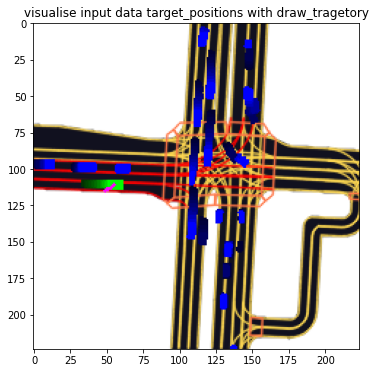

In [10]:
plt.figure(figsize= (8,6))
visualise(train_dataset, index=80)

## Training Phase

In [11]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

model=buil_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion= nn.MSELoss(reduction= 'none')



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [12]:
tr_it= iter(train_dataloader)
progress_bar= tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train=[]
for _ in progress_bar:
    try :
        data = next(tr_it)
    except StopItration: 
        tr_it = iter(train_dataloader)
        data=next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _=forward(data, model, device, criterion)
    
    ##back pass
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    

loss: 13.621976852416992 loss(avg): 32.01410040616989: 100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


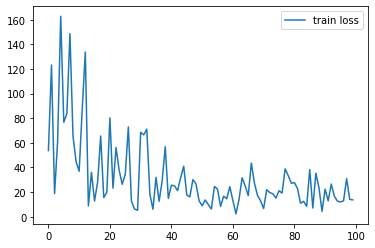

In [31]:
plt.plot(np.arange(len(losses_train)),losses_train, label="train loss")
plt.legend()
plt.show()

## Eval